In [1]:
import pandas as pd
import plotly.express as px

In [2]:
profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

color_discrete_map = {
    "ORF": "rgb(0, 158, 115)",
    "CRISPR": "rgb(213, 94, 0)",
}

gene_labels = {
    "Protein Class": "protein_class",
    "Disease Association": "disease_association",
    "CORUM Complex": "corum_complex",
    "Wikipathway": "wikipathway",
    "HGNC Gene Group": "gene-group",
}

Read phenotypic activity data

In [3]:
phenotypic_activity_df = pd.DataFrame()

for profile in profiles:
    df = pd.read_csv(f"output/phenotypic-activity-{profiles[profile]}.csv.gz")
    df["profile_type"] = profile
    phenotypic_activity_df = pd.concat(
        [phenotypic_activity_df, df], ignore_index=True, axis=0
    )

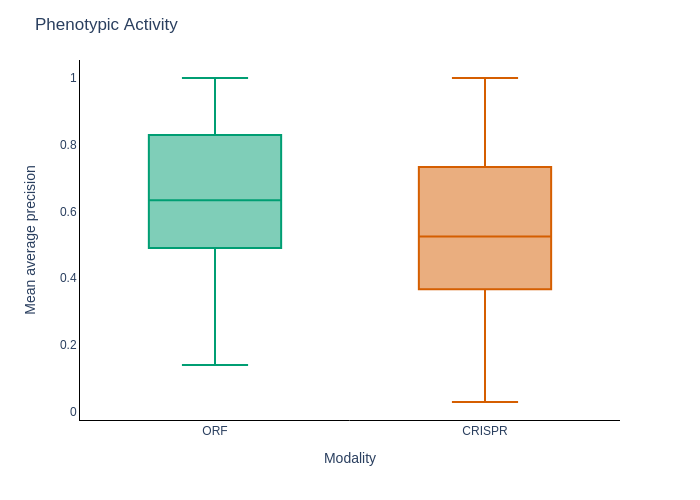

In [4]:
fig = px.box(
    phenotypic_activity_df,
    x="profile_type",
    y="mean_average_precision",
    color="profile_type",
    color_discrete_map=color_discrete_map,
).update_layout(
    title="Phenotypic Activity",
    xaxis=dict(title="Modality", linecolor="black"),
    yaxis=dict(title="Mean average precision", linecolor="black"),
    plot_bgcolor="white",
    showlegend=False,
)

fig.show("png")
fig.write_image("figures/phenotypic-activity.png", height=480, width=640, scale=2)
fig.write_image("figures/phenotypic-activity.svg", height=480, width=640, scale=2)

In [5]:
fraction_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum() / len(x))
    .reset_index()
    .rename(columns={"below_corrected_p": "fraction_retrieved"})
)

print(fraction_retrieved.to_markdown(index=False))

| profile_type   |   fraction_retrieved |
|:---------------|---------------------:|
| CRISPR         |             0.695772 |
| ORF            |             0.568964 |


In [6]:
n_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum())
    .reset_index()
    .rename(columns={"below_corrected_p": "n_retrieved"})
)

print(n_retrieved.to_markdown(index=False))

| profile_type   |   n_retrieved |
|:---------------|--------------:|
| CRISPR         |          5546 |
| ORF            |          7817 |


In [7]:
gene_label_retrieval_df = pd.DataFrame()

for gene_label in gene_labels:
    df = (
        pd.read_parquet(f"output/{gene_labels[gene_label]}_retrieval.parquet")[
            ["mean_average_precision", "below_corrected_p", "Modality"]
        ]
        .assign(gene_label=gene_label)
        .assign(modality=lambda x: x.apply(lambda y: y["Modality"], axis=1))
    )
    gene_label_retrieval_df = pd.concat(
        [gene_label_retrieval_df, df], ignore_index=True, axis=0
    )

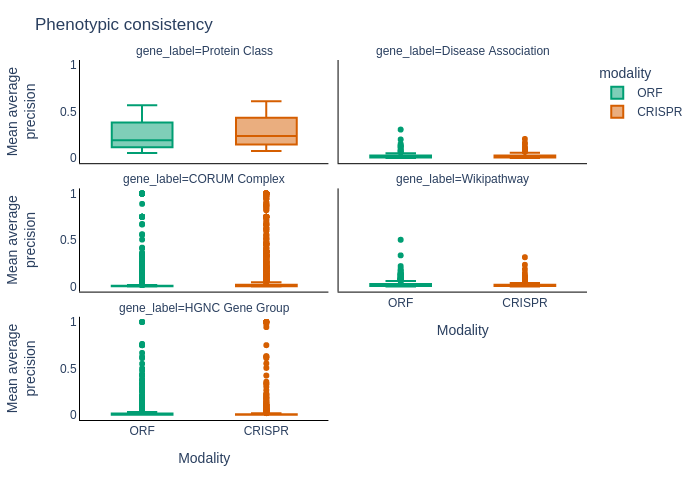

In [8]:
fig = (
    px.box(
        gene_label_retrieval_df,
        x="modality",
        y="mean_average_precision",
        color="modality",
        color_discrete_map=color_discrete_map,
        facet_col="gene_label",
        facet_col_wrap=2,
    )
    .update_layout(
        title="Phenotypic consistency",
        xaxis1=dict(title="Modality",linecolor="black"),
        xaxis3=dict(linecolor="black"),
        xaxis4=dict(title="Modality", linecolor="black", showticklabels=True),
        xaxis5=dict(linecolor="black"),
        xaxis6=dict(linecolor="black"),
        yaxis1=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis3=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis4=dict(linecolor="black"),
        yaxis5=dict(title=f"Mean average<br>precision",linecolor="black"),
        yaxis6=dict(linecolor="black"),
        plot_bgcolor="white",
    )
)

fig.show("png")
fig.write_image("figures/phenotypic-consistency-gene-labels.png", height=480, width=640, scale=2)
fig.write_image("figures/phenotypic-consistency-gene-labels.svg", height=480, width=640, scale=2)

In [9]:
print(
    gene_label_retrieval_df.query("below_corrected_p == True")
    .groupby(["modality", "gene_label"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="modality", columns="gene_label", values="mean_average_precision")
    .sort_index()
    [list(gene_labels.keys())]
    .to_markdown()
)

| modality   |   Protein Class |   Disease Association |   CORUM Complex |   Wikipathway |   HGNC Gene Group |
|:-----------|----------------:|----------------------:|----------------:|--------------:|------------------:|
| CRISPR     |             nan |                     3 |             369 |           152 |                89 |
| ORF        |               5 |                     2 |             103 |           347 |               196 |
